In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage, signal
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import zoom
import tensorflow as tf
from tensorflow import keras
import pickle
from typing import Tuple, List, Dict
import warnings
import os

warnings.filterwarnings('ignore')

# Import radar components from Part 1
from radar_simulation import RadarSignalGenerator, RadarProcessor, RadarVisualizer

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
os.makedirs('outputs_hidden', exist_ok=True)


In [2]:
class ClutteredSceneGenerator:
    """
    Generate complex cluttered radar scenes with hidden metal objects.
    Metal objects are intentionally placed near clutter to simulate occlusion.
    """
    
    def __init__(self, radar_gen, processor):
        self.radar_gen = radar_gen
        self.processor = processor
        
    def generate_cluttered_scene(self, 
                                 num_metal: int = 2,
                                 num_clutter: int = 5,
                                 occlusion_level: str = 'medium') -> Tuple[np.ndarray, List[Dict]]:
        """
        Generate a cluttered scene with metal objects and non-metal clutter.
        
        Args:
            num_metal: Number of metal objects to generate
            num_clutter: Number of clutter (non-metal) objects
            occlusion_level: 'low', 'medium', or 'high' - determines clutter strength
            
        Returns:
            signal: 2D radar signal array
            targets: List of all objects with their properties
        """
        targets = []
        
        # Define clutter RCS based on occlusion level
        # Lower RCS = weaker reflections from non-metal objects
        clutter_rcs_range = {
            'low': (0.2, 0.8),      # Weak clutter
            'medium': (0.3, 1.5),   # Moderate clutter
            'high': (0.5, 2.5)      # Strong clutter
        }
        rcs_min, rcs_max = clutter_rcs_range.get(occlusion_level, (0.3, 1.5))
        
        # Generate clutter objects (non-metal)
        for i in range(num_clutter):
            targets.append({
                'range': np.random.uniform(0.5, 5.5),  # Random distance
                'velocity': np.random.uniform(-0.8, 0.8),  # Slow movement
                'rcs': np.random.uniform(rcs_min, rcs_max),  # Weak reflection
                'is_metal': False,
                'is_clutter': True
            })
        
        # Generate metal objects (potentially hidden by clutter)
        for i in range(num_metal):
            # 70% chance: Place metal near existing clutter (hidden)
            # 30% chance: Place metal in open space
            if np.random.rand() > 0.3:
                # Pick a random clutter object to hide near
                clutter_idx = np.random.randint(len(targets))
                base_range = targets[clutter_idx]['range']
                # Place metal slightly offset from clutter
                target_range = base_range + np.random.uniform(-0.4, 0.4)
            else:
                # Place in open space
                target_range = np.random.uniform(1.0, 5.0)
            
            # Metal objects have MUCH higher RCS (18-30 vs 0.2-2.5 for clutter)
            targets.append({
                'range': max(0.5, min(5.5, target_range)),  # Clamp to valid range
                'velocity': np.random.uniform(-2.5, 2.5),  # Can move faster
                'rcs': np.random.uniform(18.0, 30.0),  # STRONG reflection
                'is_metal': True,
                'is_clutter': False
            })
        
        # Add noise based on occlusion level (more clutter = more noise)
        noise_levels = {'low': 0.02, 'medium': 0.04, 'high': 0.06}
        noise = noise_levels.get(occlusion_level, 0.04)
        
        # Generate the radar signal
        signal = self.radar_gen.generate_2d_signal(targets, noise_power=noise)
        
        return signal, targets


In [3]:
class AdvancedRadarProcessor:
    """
    Advanced signal processing techniques for detecting objects in cluttered scenes.
    Implements CFAR detection, background subtraction, and noise filtering.
    """
    
    @staticmethod
    def cfar_detector(rd_map: np.ndarray, 
                      guard_cells: int = 2,
                      training_cells: int = 12,
                      pfa: float = 1e-3) -> np.ndarray:
        """
        CFAR (Constant False Alarm Rate) Detector.
        Adaptively sets detection threshold based on local noise level.
        
        Args:
            rd_map: Range-Doppler magnitude map
            guard_cells: Cells around target to exclude from noise estimation
            training_cells: Cells used to estimate local noise
            pfa: Probability of false alarm (lower = stricter)
            
        Returns:
            Binary detection map (1 = detection, 0 = no detection)
        """
        threshold_factor = -np.log(pfa)
        detection_map = np.zeros_like(rd_map)
        
        pad_size = guard_cells + training_cells
        rd_padded = np.pad(rd_map, pad_size, mode='edge')
        
        # Slide window over entire map
        for i in range(rd_map.shape[0]):
            for j in range(rd_map.shape[1]):
                # Extract local window
                window = rd_padded[i:i+2*pad_size+1, j:j+2*pad_size+1]
                
                # Create mask: exclude guard cells and center cell
                mask = np.ones_like(window, dtype=bool)
                center = pad_size
                mask[center-guard_cells:center+guard_cells+1, 
                     center-guard_cells:center+guard_cells+1] = False
                
                # Estimate noise from training cells
                noise_estimate = np.mean(window[mask])
                threshold = noise_estimate * threshold_factor
                
                # Check if center cell exceeds threshold
                if rd_padded[i+pad_size, j+pad_size] > threshold:
                    detection_map[i, j] = 1
        
        return detection_map
    
    @staticmethod
    def background_subtraction(rd_map: np.ndarray, 
                               percentile: int = 15) -> np.ndarray:
        """
        Remove static background clutter using percentile filtering.
        
        Args:
            rd_map: Range-Doppler map
            percentile: Percentile for background estimation (lower = more aggressive)
            
        Returns:
            Foreground (moving objects) map
        """
        # Estimate static background
        background = ndimage.percentile_filter(rd_map, percentile, size=15)
        
        # Subtract and clip negative values
        foreground = rd_map - background
        foreground = np.maximum(foreground, 0)
        
        return foreground
    
    @staticmethod
    def morphological_filtering(detection_map: np.ndarray,
                                operation: str = 'close') -> np.ndarray:
        """
        Clean up detection map using morphological operations.
        - 'open': Remove small noise
        - 'close': Fill small holes
        - 'both': Do both
        
        Args:
            detection_map: Binary detection map
            operation: Type of morphological operation
            
        Returns:
            Cleaned detection map
        """
        kernel = np.ones((3, 3))
        
        if operation == 'open' or operation == 'both':
            detection_map = ndimage.binary_opening(detection_map, structure=kernel)
        
        if operation == 'close' or operation == 'both':
            detection_map = ndimage.binary_closing(detection_map, structure=kernel)
        
        return detection_map.astype(float)
    
    @staticmethod
    def adaptive_noise_filter(rd_map: np.ndarray, 
                              filter_size: int = 5) -> np.ndarray:
        """
        Adaptive noise filtering (Wiener-like filter).
        Preserves edges while reducing noise.
        
        Args:
            rd_map: Range-Doppler map
            filter_size: Size of local filtering window
            
        Returns:
            Filtered map
        """
        # Calculate local statistics
        local_mean = ndimage.uniform_filter(rd_map, size=filter_size)
        local_var = ndimage.uniform_filter(rd_map**2, size=filter_size) - local_mean**2
        local_var = np.maximum(local_var, 0)
        
        # Estimate global noise variance
        noise_var = np.median(local_var)
        
        # Apply adaptive filter
        # Where local variance is high (edges), keep original
        # Where local variance is low (noise), use smoothed version
        filtered = local_mean + np.maximum(0, (local_var - noise_var) / (local_var + 1e-10)) * (rd_map - local_mean)
        
        return filtered



In [4]:
class HiddenObjectDetectionPipeline:
    """
    Complete pipeline for detecting hidden metal objects in cluttered scenes.
    Combines preprocessing, detection, segmentation, and classification.
    """
    
    def __init__(self, model_path: str, processor: RadarProcessor):
        """
        Initialize pipeline with trained model.
        
        Args:
            model_path: Path to trained Keras model (.keras file)
            processor: RadarProcessor instance from Part 1
        """
        self.model = keras.models.load_model(model_path)
        self.processor = processor
        self.advanced_processor = AdvancedRadarProcessor()
        print(f"✓ Model loaded from: {model_path}")
        
    def preprocess_scene(self, signal: np.ndarray,
                        apply_cfar: bool = True,
                        apply_background_sub: bool = True,
                        apply_noise_filter: bool = True) -> Dict[str, np.ndarray]:
        """
        Apply complete preprocessing pipeline to raw radar signal.
        
        Pipeline stages:
        1. Range FFT → Doppler FFT → Magnitude (dB)
        2. Background subtraction (remove static clutter)
        3. Adaptive noise filtering
        4. CFAR detection (find peaks)
        5. Morphological filtering (clean detections)
        
        Args:
            signal: Raw 2D radar signal [num_chirps x adc_samples]
            apply_cfar: Enable CFAR detection
            apply_background_sub: Enable background subtraction
            apply_noise_filter: Enable noise filtering
            
        Returns:
            Dictionary with processed maps at each stage
        """
        results = {}
        
        # Stage 1: Basic radar processing (Range-Doppler map)
        range_fft = self.processor.range_fft(signal, window='hann')
        rd_map = self.processor.doppler_fft(range_fft, window='hann')
        rd_mag = self.processor.compute_magnitude(rd_map, db=True)
        results['original'] = rd_mag
        
        # Stage 2: Background subtraction
        if apply_background_sub:
            rd_mag = self.advanced_processor.background_subtraction(rd_mag, percentile=15)
            results['background_subtracted'] = rd_mag
        
        # Stage 3: Noise filtering
        if apply_noise_filter:
            rd_mag = self.advanced_processor.adaptive_noise_filter(rd_mag, filter_size=5)
            results['noise_filtered'] = rd_mag
        
        # Stage 4: CFAR detection
        if apply_cfar:
            detection_map = self.advanced_processor.cfar_detector(
                rd_mag, 
                guard_cells=2, 
                training_cells=12, 
                pfa=1e-3
            )
            # Clean up detections
            detection_map = self.advanced_processor.morphological_filtering(
                detection_map, 
                operation='both'
            )
            results['cfar_detection'] = detection_map
        
        results['final'] = rd_mag
        
        return results
    
    def segment_and_classify(self, rd_map: np.ndarray,
                            detection_map: np.ndarray = None,
                            confidence_threshold: float = 0.3) -> List[Dict]:
        """
        Segment detected objects and classify each as metal or non-metal.
        
        Args:
            rd_map: Processed Range-Doppler map
            detection_map: Binary detection map (if None, will compute CFAR)
            confidence_threshold: Minimum probability to classify as metal
            
        Returns:
            List of detected objects with classifications and confidence scores
        """
        # If no detection map provided, compute it
        if detection_map is None:
            detection_map = self.advanced_processor.cfar_detector(rd_map)
        
        # Find connected components (individual objects)
        labeled, num_features = ndimage.label(detection_map)
        
        detections = []
        
        for obj_id in range(1, num_features + 1):
            # Extract object region
            obj_mask = (labeled == obj_id)
            coords = np.argwhere(obj_mask)
            
            # Skip tiny detections (likely noise)
            if len(coords) < 3:
                continue
            
            # Get bounding box
            min_row, min_col = coords.min(axis=0)
            max_row, max_col = coords.max(axis=0)
            
            # Expand box slightly for context
            margin = 5
            min_row = max(0, min_row - margin)
            min_col = max(0, min_col - margin)
            max_row = min(rd_map.shape[0] - 1, max_row + margin)
            max_col = min(rd_map.shape[1] - 1, max_col + margin)
            
            # Extract and resize patch to model input size (128x256)
            patch = rd_map[min_row:max_row+1, min_col:max_col+1]
            
            # Resize to model input
            zoom_factors = (128 / patch.shape[0], 256 / patch.shape[1])
            patch_resized = zoom(patch, zoom_factors, order=1)
            
            # Normalize (same as training)
            patch_normalized = (patch_resized - np.mean(rd_map)) / (np.std(rd_map) + 1e-8)
            patch_input = patch_normalized[np.newaxis, :, :, np.newaxis]
            
            # Classify with CNN
            prediction = self.model.predict(patch_input, verbose=0)
            prob_metal = prediction[0, 1]  # Probability of metal class
            
            # Store detection
            detections.append({
                'bbox': (min_row, min_col, max_row, max_col),
                'centroid': (coords[:, 0].mean(), coords[:, 1].mean()),
                'area': len(coords),
                'prob_metal': float(prob_metal),
                'is_metal': prob_metal > confidence_threshold  # Classification decision
            })
        
        return detections


In [5]:
def generate_hidden_object_dataset(num_samples: int = 500) -> Tuple:
    """
    Generate test dataset of cluttered scenes with hidden metal objects.
    
    Args:
        num_samples: Number of test scenes to generate
        
    Returns:
        X_signals: Array of radar signals
        y_labels: Array of labels (all 1, since all contain metal)
        metadata: List of dictionaries with scene information
    """
    radar_gen = RadarSignalGenerator()
    processor = RadarProcessor()
    scene_gen = ClutteredSceneGenerator(radar_gen, processor)
    
    X_signals = []
    y_labels = []
    metadata = []
    
    occlusion_levels = ['low', 'medium', 'high']
    
    print(f"\nGenerating {num_samples} cluttered test scenes...")
    print("This may take a few minutes...\n")
    
    for i in range(num_samples):
        # Randomize scene complexity
        occlusion = np.random.choice(occlusion_levels)
        num_metal = np.random.randint(1, 4)  # 1-3 metal objects
        num_clutter = np.random.randint(3, 8)  # 3-7 clutter objects
        
        # Generate scene
        signal, targets = scene_gen.generate_cluttered_scene(
            num_metal=num_metal,
            num_clutter=num_clutter,
            occlusion_level=occlusion
        )
        
        X_signals.append(signal)
        y_labels.append(1)  # All scenes contain metal
        metadata.append({
            'num_metal': num_metal,
            'num_clutter': num_clutter,
            'occlusion': occlusion,
            'targets': targets
        })
        
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i + 1}/{num_samples} scenes generated")
    
    print(f"\n✓ Dataset generation complete!")
    print(f"  Total scenes: {len(X_signals)}")
    print(f"  Signal shape: {X_signals[0].shape}")
    
    return np.array(X_signals), np.array(y_labels), metadata

# Generate the test dataset
X_test, y_test, metadata = generate_hidden_object_dataset(num_samples=1500)

Radar Configuration:
  Range Resolution: 0.037 m
  Max Range: 0.00 m
  Velocity Resolution: 0.380 m/s

Generating 1500 cluttered test scenes...
This may take a few minutes...

  Progress: 100/1500 scenes generated
  Progress: 200/1500 scenes generated
  Progress: 300/1500 scenes generated
  Progress: 400/1500 scenes generated
  Progress: 500/1500 scenes generated
  Progress: 600/1500 scenes generated
  Progress: 700/1500 scenes generated
  Progress: 800/1500 scenes generated
  Progress: 900/1500 scenes generated
  Progress: 1000/1500 scenes generated
  Progress: 1100/1500 scenes generated
  Progress: 1200/1500 scenes generated
  Progress: 1300/1500 scenes generated
  Progress: 1400/1500 scenes generated
  Progress: 1500/1500 scenes generated

✓ Dataset generation complete!
  Total scenes: 1500
  Signal shape: (128, 256)


In [6]:
def evaluate_pipeline(pipeline: HiddenObjectDetectionPipeline,
                     X_test: np.ndarray,
                     metadata: List[Dict]) -> Tuple[Dict, Dict]:
    """
    Comprehensive evaluation of the detection pipeline.
    
    Metrics computed:
    - Detection rate: % of metal objects found
    - Precision: % of detections that are actually metal
    - Recall: % of metal objects detected
    - F1-Score: Harmonic mean of precision and recall
    
    Args:
        pipeline: Configured detection pipeline
        X_test: Test signals
        metadata: Ground truth information
        
    Returns:
        summary: Dictionary of aggregate metrics
        results: Dictionary of per-sample metrics
    """
    results = {
        'detection_rate': [],
        'false_positives': [],
        'true_positives': [],
        'precision': [],
        'recall': []
    }
    
    print("\n" + "=" * 70)
    print("EVALUATING PIPELINE ON CLUTTERED SCENES")
    print("=" * 70)
    
    for i, (signal, meta) in enumerate(zip(X_test, metadata)):
        # Process scene through pipeline
        processed = pipeline.preprocess_scene(signal)
        
        # Detect and classify objects
        detections = pipeline.segment_and_classify(
            processed['final'],
            processed.get('cfar_detection'),
            confidence_threshold=0.3  # Lower threshold for better recall
        )
        
        # Count metal detections
        metal_detected = sum(1 for d in detections if d['is_metal'])
        actual_metal = meta['num_metal']
        
        # Calculate metrics
        tp = min(metal_detected, actual_metal)  # True positives
        fp = max(0, metal_detected - actual_metal)  # False positives
        fn = max(0, actual_metal - metal_detected)  # False negatives
        
        results['true_positives'].append(tp)
        results['false_positives'].append(fp)
        results['detection_rate'].append(tp / actual_metal if actual_metal > 0 else 0)
        
        # Precision and Recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        results['precision'].append(precision)
        results['recall'].append(recall)
        
        if (i + 1) % 100 == 0:
            print(f"  Evaluated {i + 1}/{len(X_test)} scenes...")
    
    # Compute aggregate statistics
    summary = {
        'mean_detection_rate': np.mean(results['detection_rate']),
        'mean_precision': np.mean(results['precision']),
        'mean_recall': np.mean(results['recall']),
        'mean_f1': 2 * np.mean(results['precision']) * np.mean(results['recall']) / 
                   (np.mean(results['precision']) + np.mean(results['recall']) + 1e-10),
        'total_tp': sum(results['true_positives']),
        'total_fp': sum(results['false_positives'])
    }
    
    return summary, results



In [7]:
def visualize_detection_results(pipeline: HiddenObjectDetectionPipeline,
                                signal: np.ndarray,
                                metadata: Dict,
                                save_path: str = None):
    """
    Create comprehensive visualization of detection pipeline results.
    
    Shows:
    - Original Range-Doppler map
    - Background subtracted map
    - Noise filtered map
    - CFAR detection map
    - Final detections with bounding boxes
    - Detection confidence scores
    
    Args:
        pipeline: Detection pipeline
        signal: Raw radar signal
        metadata: Ground truth information
        save_path: Path to save figure (optional)
    """
    # Process scene
    processed = pipeline.preprocess_scene(signal)
    detections = pipeline.segment_and_classify(
        processed['final'],
        processed.get('cfar_detection'),
        confidence_threshold=0.3
    )
    
    # Create figure
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Original Range-Doppler
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(processed['original'], aspect='auto', cmap='jet', origin='lower')
    ax1.set_title('Original Range-Doppler', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Range Bin')
    ax1.set_ylabel('Doppler Bin')
    plt.colorbar(im1, ax=ax1, label='Magnitude (dB)')
    
    # 2. Background Subtracted
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(processed.get('background_subtracted', processed['original']), 
                     aspect='auto', cmap='jet', origin='lower')
    ax2.set_title('Background Subtracted', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Range Bin')
    ax2.set_ylabel('Doppler Bin')
    plt.colorbar(im2, ax=ax2, label='Magnitude (dB)')
    
    # 3. Noise Filtered
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(processed.get('noise_filtered', processed['final']), 
                     aspect='auto', cmap='jet', origin='lower')
    ax3.set_title('Noise Filtered', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Range Bin')
    ax3.set_ylabel('Doppler Bin')
    plt.colorbar(im3, ax=ax3, label='Magnitude (dB)')
    
    # 4. CFAR Detection
    ax4 = fig.add_subplot(gs[1, 0])
    im4 = ax4.imshow(processed.get('cfar_detection', np.zeros_like(processed['final'])), 
                     aspect='auto', cmap='binary', origin='lower')
    ax4.set_title('CFAR Detection Map', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Range Bin')
    ax4.set_ylabel('Doppler Bin')
    plt.colorbar(im4, ax=ax4, label='Detection')
    
    # 5. Final Detections with Bounding Boxes
    ax5 = fig.add_subplot(gs[1, 1])
    im5 = ax5.imshow(processed['final'], aspect='auto', cmap='jet', origin='lower')
    
    # Draw bounding boxes and count
    metal_count = 0
    non_metal_count = 0
    for det in detections:
        min_r, min_c, max_r, max_c = det['bbox']
        color = 'lime' if det['is_metal'] else 'red'
        rect = plt.Rectangle((min_c, min_r), max_c - min_c, max_r - min_r,
                            fill=False, edgecolor=color, linewidth=2)
        ax5.add_patch(rect)
        
        if det['is_metal']:
            metal_count += 1
        else:
            non_metal_count += 1
    
    ax5.set_title(f'Detections (Green=Metal, Red=Non-Metal)', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Range Bin')
    ax5.set_ylabel('Doppler Bin')
    plt.colorbar(im5, ax=ax5, label='Magnitude (dB)')
    
    # 6. Statistics Panel
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    stats_text = f"""
    Scene Statistics:
    ═══════════════════
    Actual Metal Objects: {metadata['num_metal']}
    Clutter Objects: {metadata['num_clutter']}
    Occlusion Level: {metadata['occlusion']}
    
    Detection Results:
    ═══════════════════
    Metal Detected: {metal_count}
    Non-Metal Detected: {non_metal_count}
    Total Detections: {len(detections)}
    
    Detection Rate: {metal_count/metadata['num_metal']*100:.1f}%
    
    Detection Confidence:
    ═══════════════════
    """
    
    for i, det in enumerate(detections[:5]):  # Show top 5
        stats_text += f"\n  Obj {i+1}: {det['prob_metal']*100:.1f}% metal"
    
    ax6.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center')
    
    # 7. Confidence Scores
    ax7 = fig.add_subplot(gs[2, :])
    if detections:
        confidences = [d['prob_metal'] for d in detections]
        colors = ['lime' if d['is_metal'] else 'red' for d in detections]
        bars = ax7.bar(range(len(confidences)), confidences, color=colors, alpha=0.7, edgecolor='black')
        ax7.axhline(y=0.3, color='black', linestyle='--', linewidth=2, label='Decision Threshold (30%)')
        ax7.set_xlabel('Detection ID', fontsize=12)
        ax7.set_ylabel('Metal Probability', fontsize=12)
        ax7.set_title('Detection Confidence Scores', fontweight='bold', fontsize=14)
        ax7.set_ylim([0, 1])
        ax7.legend(fontsize=10)
        ax7.grid(True, alpha=0.3, axis='y')
    else:
        ax7.text(0.5, 0.5, 'No detections found', ha='center', va='center', fontsize=14)
        ax7.set_xlim([0, 1])
        ax7.set_ylim([0, 1])
    
    plt.suptitle(f'Hidden Object Detection Pipeline - {metadata["occlusion"].upper()} Occlusion', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


In [8]:
# Initialize components
print("INITIALIZING DETECTION PIPELINE")


processor = RadarProcessor()

# IMPORTANT: Update this path to your trained model
MODEL_PATH = 'classification_model_outputs\metal_classifier_improved.keras'

pipeline = HiddenObjectDetectionPipeline(
    model_path=MODEL_PATH,
    processor=processor
)

# Run evaluation
summary, detailed_results = evaluate_pipeline(pipeline, X_test, metadata)



INITIALIZING DETECTION PIPELINE
✓ Model loaded from: classification_model_outputs\metal_classifier_improved.keras

EVALUATING PIPELINE ON CLUTTERED SCENES
  Evaluated 100/1500 scenes...
  Evaluated 200/1500 scenes...
  Evaluated 300/1500 scenes...
  Evaluated 400/1500 scenes...
  Evaluated 500/1500 scenes...
  Evaluated 600/1500 scenes...
  Evaluated 700/1500 scenes...
  Evaluated 800/1500 scenes...
  Evaluated 900/1500 scenes...
  Evaluated 1000/1500 scenes...
  Evaluated 1100/1500 scenes...
  Evaluated 1200/1500 scenes...
  Evaluated 1300/1500 scenes...
  Evaluated 1400/1500 scenes...
  Evaluated 1500/1500 scenes...


In [9]:
# Print results
print("FINAL EVALUATION RESULTS")

print(f"\nOverall Performance:")
print(f"  Mean Detection Rate: {summary['mean_detection_rate']*100:.1f}%")
print(f"  Mean Precision:      {summary['mean_precision']*100:.1f}%")
print(f"  Mean Recall:         {summary['mean_recall']*100:.1f}%")
print(f"  Mean F1-Score:       {summary['mean_f1']*100:.1f}%")
print(f"\nTotal Detections:")
print(f"  True Positives:  {summary['total_tp']}")
print(f"  False Positives: {summary['total_fp']}")


FINAL EVALUATION RESULTS

Overall Performance:
  Mean Detection Rate: 16.1%
  Mean Precision:      23.4%
  Mean Recall:         16.1%
  Mean F1-Score:       19.1%

Total Detections:
  True Positives:  387
  False Positives: 13



Processing low occlusion scene...
✓ Saved: outputs_hidden/detection_low_occlusion.png


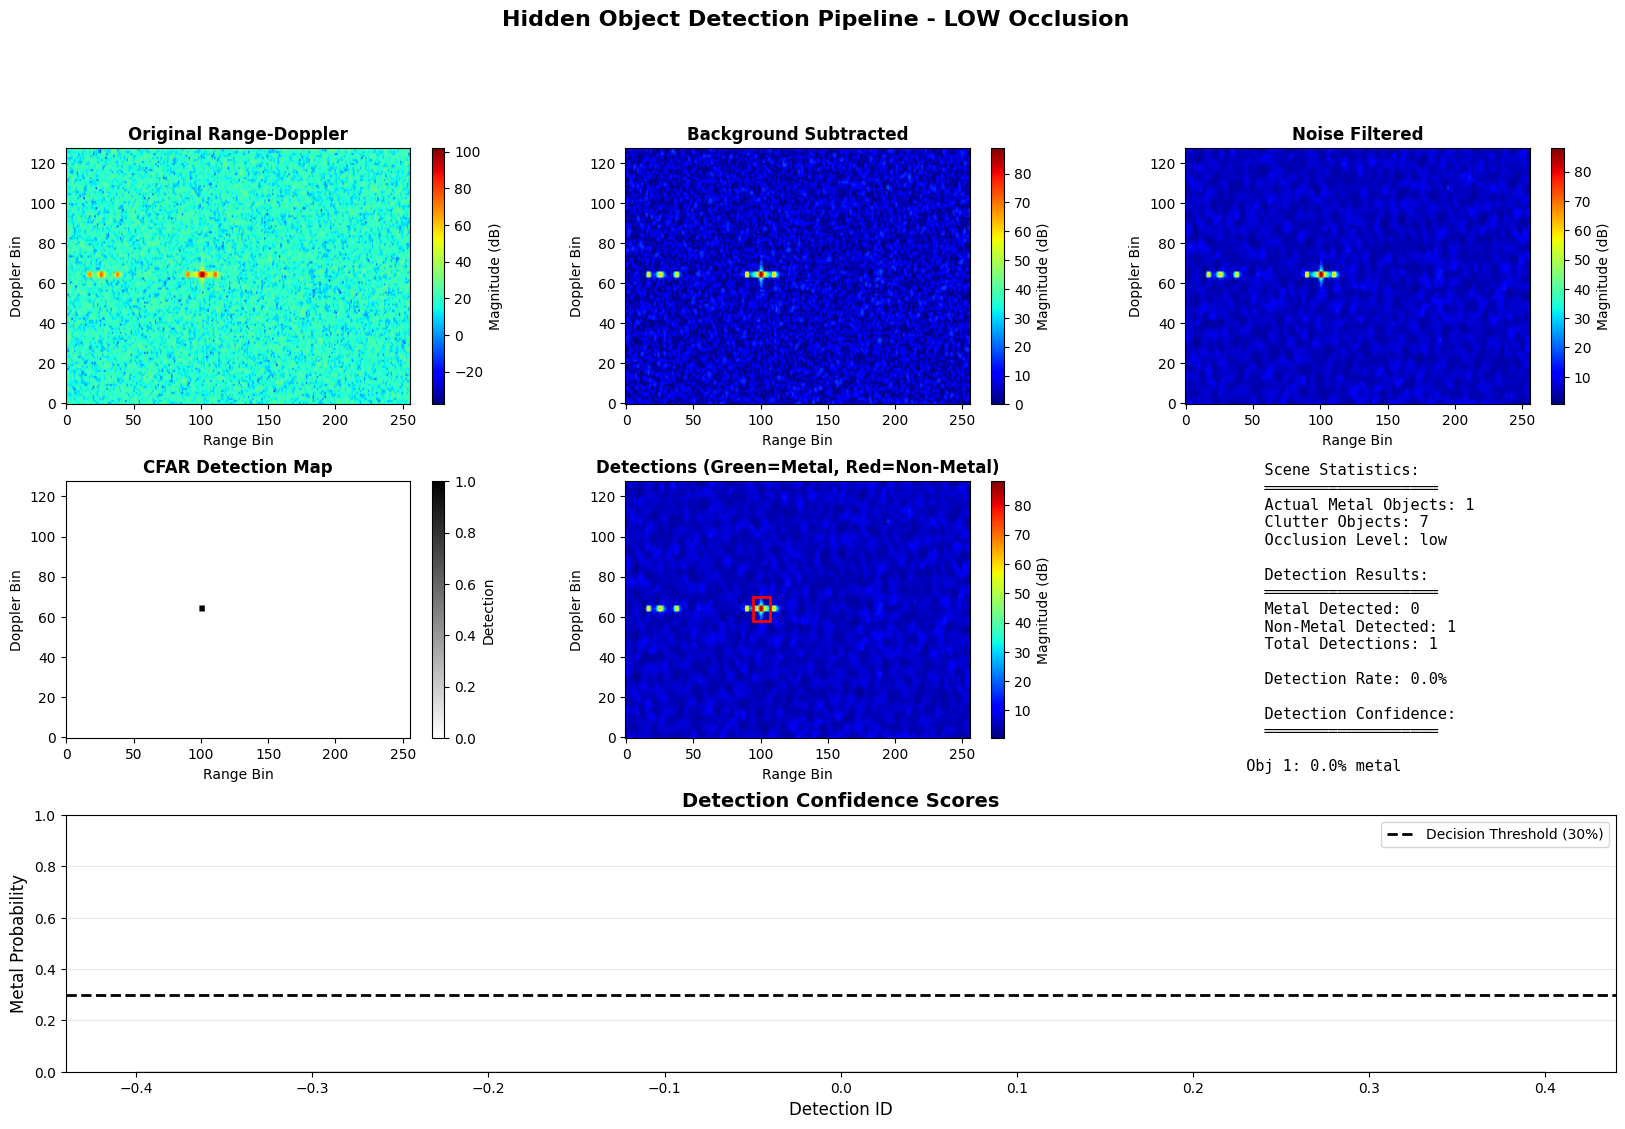


Processing medium occlusion scene...
✓ Saved: outputs_hidden/detection_medium_occlusion.png


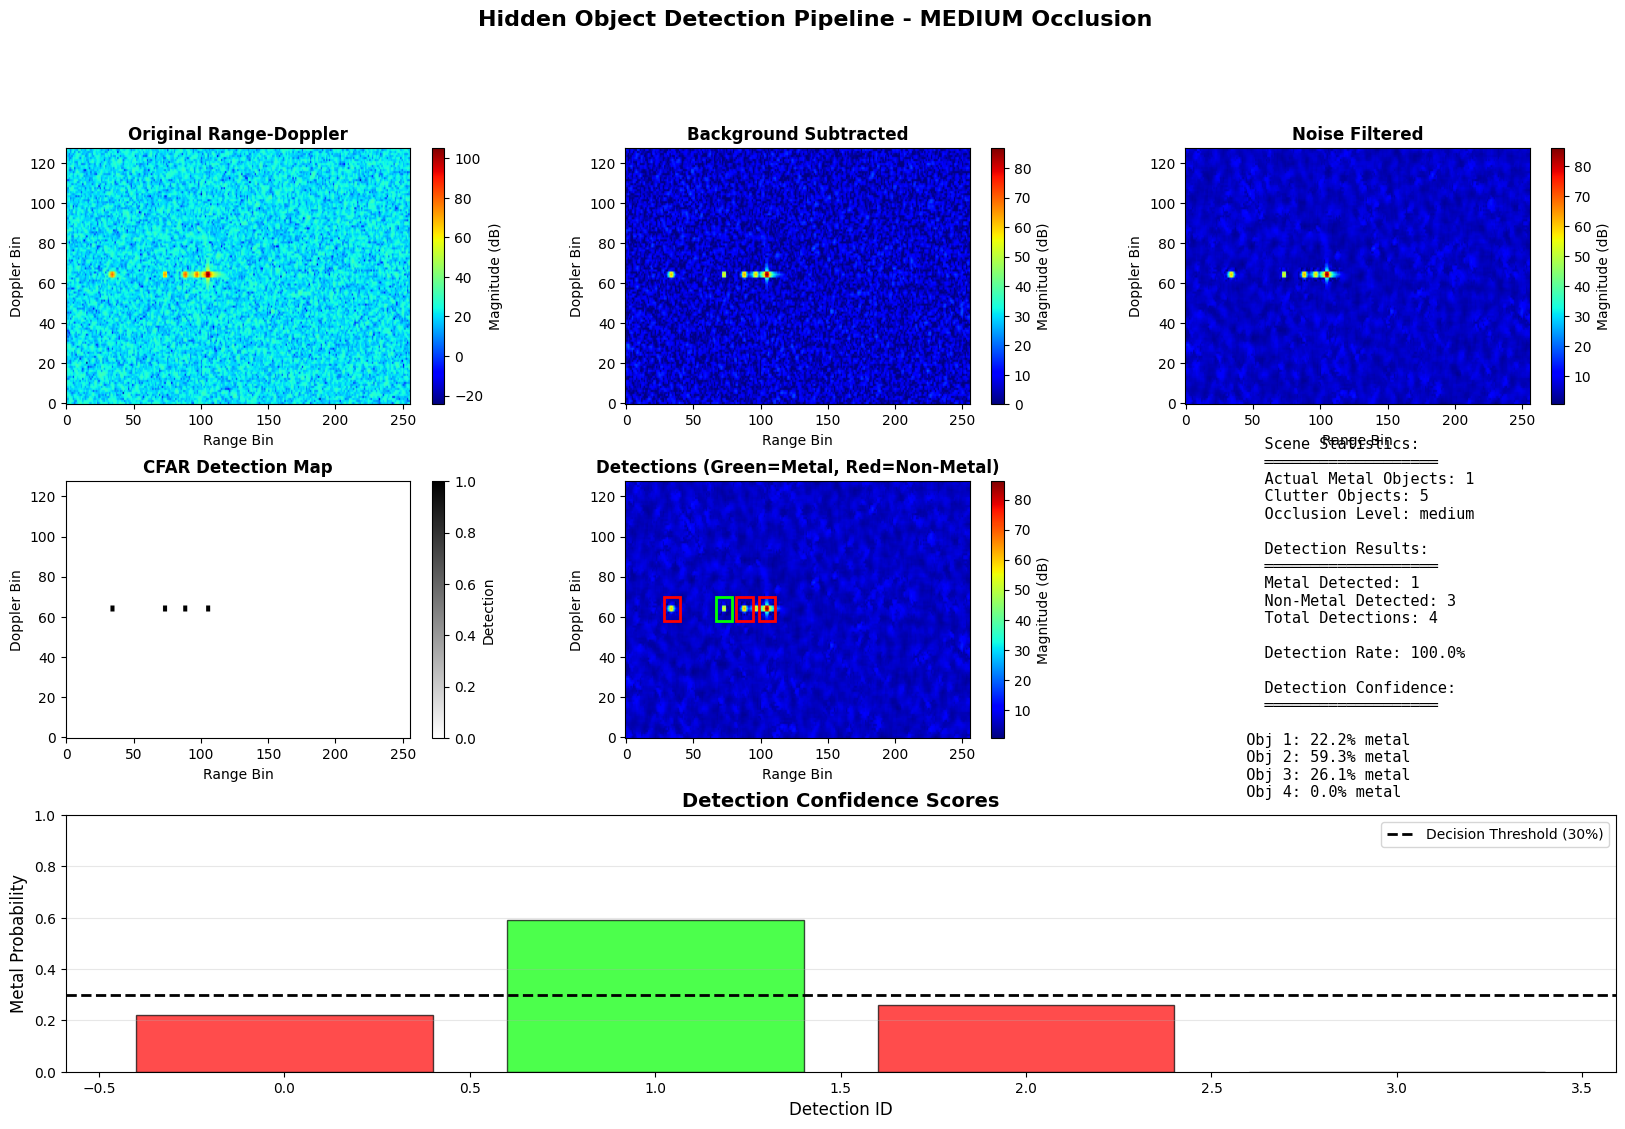


Processing high occlusion scene...
✓ Saved: outputs_hidden/detection_high_occlusion.png


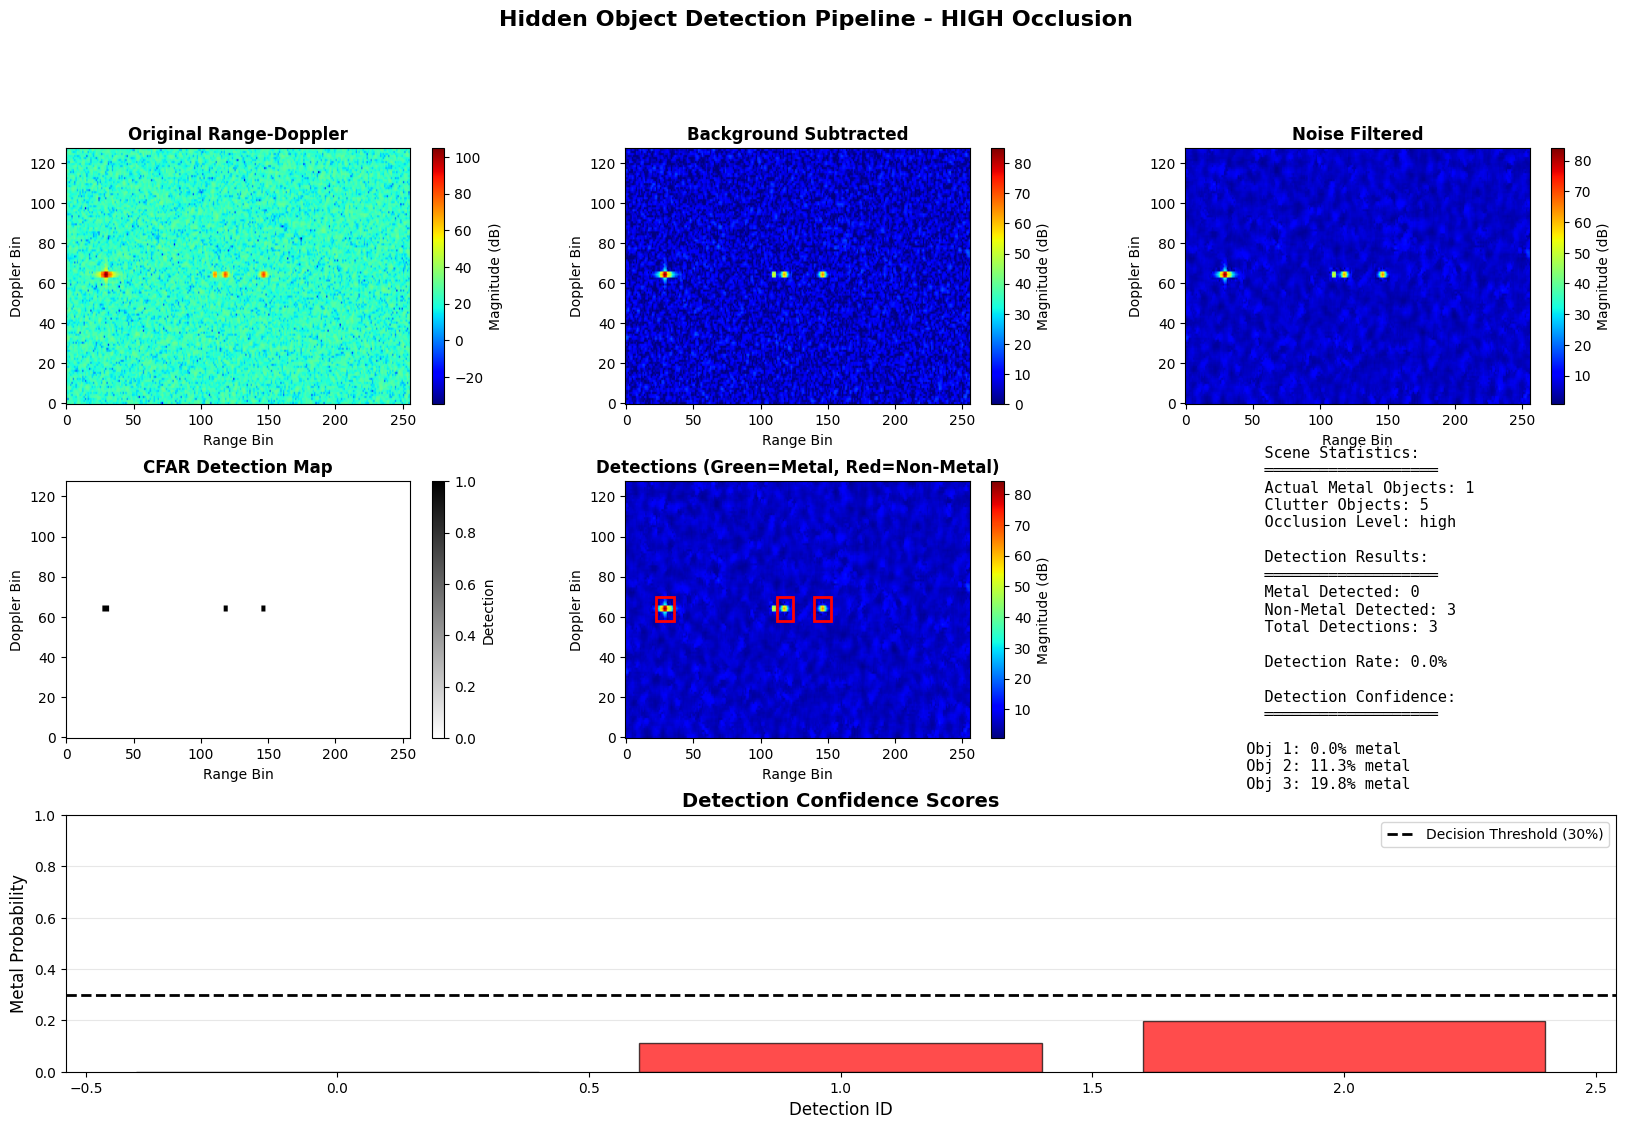

In [10]:
#print("GENERATING VISUALIZATIONS FOR SAMPLE SCENES")


# Visualize one scene from each occlusion level
for occlusion in ['low', 'medium', 'high']:
    # Find a sample with this occlusion level
    idx = next(j for j, m in enumerate(metadata) if m['occlusion'] == occlusion)
    
    print(f"\nProcessing {occlusion} occlusion scene...")
    visualize_detection_results(
        pipeline,
        X_test[idx],
        metadata[idx],
        save_path=f'outputs_hidden/detection_{occlusion}_occlusion.png'
    )


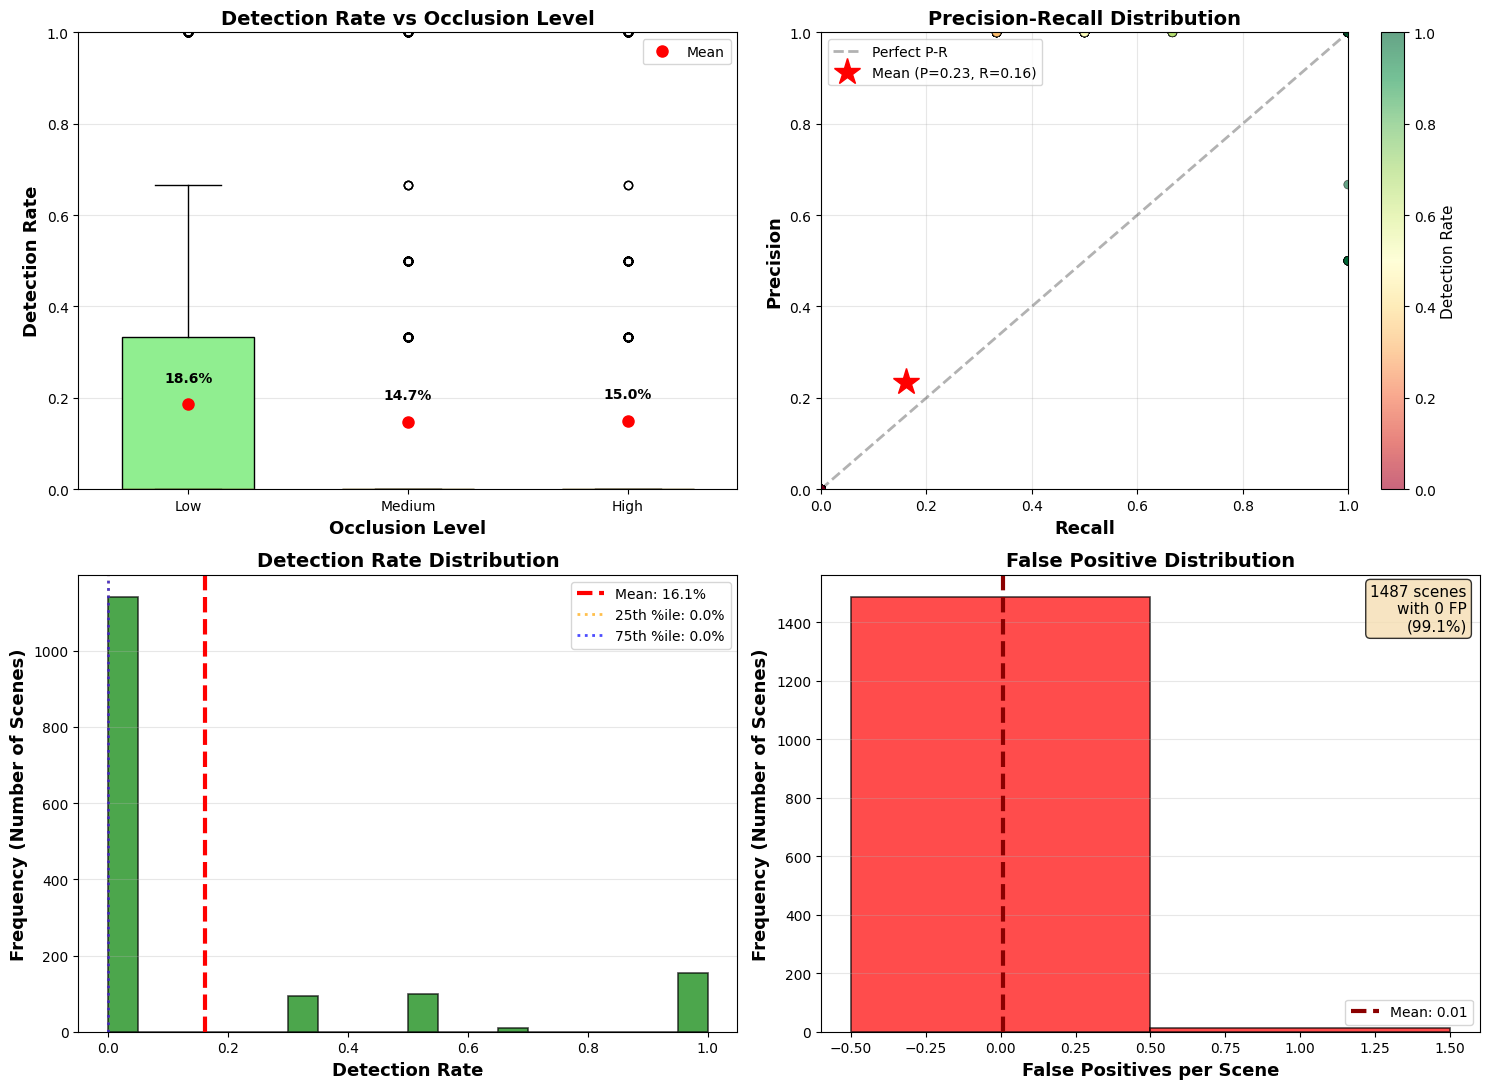

In [11]:
# Plot aggregate statistics across all test scenes

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Detection Rate by Occlusion Level
occlusion_stats = {'low': [], 'medium': [], 'high': []}
for rate, meta in zip(detailed_results['detection_rate'], metadata):
    occlusion_stats[meta['occlusion']].append(rate)

ax1 = axes[0, 0]
positions = [1, 2, 3]
box_data = [occlusion_stats['low'], occlusion_stats['medium'], occlusion_stats['high']]
bp = ax1.boxplot(box_data, positions=positions, labels=['Low', 'Medium', 'High'],
                  patch_artist=True, widths=0.6)

# Color the boxes
colors = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Calculate and display means
means = [np.mean(data) for data in box_data]
for pos, mean in zip(positions, means):
    ax1.plot(pos, mean, 'ro', markersize=8, label='Mean' if pos == 1 else '')

ax1.set_ylabel('Detection Rate', fontsize=13, fontweight='bold')
ax1.set_xlabel('Occlusion Level', fontsize=13, fontweight='bold')
ax1.set_title('Detection Rate vs Occlusion Level', fontweight='bold', fontsize=14)
ax1.set_ylim([0, 1.0])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend()

# Add mean values as text
for pos, mean in zip(positions, means):
    ax1.text(pos, mean + 0.05, f'{mean*100:.1f}%', ha='center', fontweight='bold')

# 2. Precision-Recall Distribution
ax2 = axes[0, 1]
scatter = ax2.scatter(detailed_results['recall'], detailed_results['precision'], 
            alpha=0.6, s=40, c=detailed_results['detection_rate'], 
            cmap='RdYlGn', edgecolors='black', linewidth=0.5)

# Add diagonal line (perfect precision-recall)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2, label='Perfect P-R')

# Add mean point
mean_precision = np.mean(detailed_results['precision'])
mean_recall = np.mean(detailed_results['recall'])
ax2.plot(mean_recall, mean_precision, 'r*', markersize=20, 
         label=f'Mean (P={mean_precision:.2f}, R={mean_recall:.2f})')

ax2.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax2.set_title('Precision-Recall Distribution', fontweight='bold', fontsize=14)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Detection Rate', fontsize=11)

# 3. Detection Rate Distribution
ax3 = axes[1, 0]
bins = np.linspace(0, 1, 21)
ax3.hist(detailed_results['detection_rate'], bins=bins, color='green', 
         alpha=0.7, edgecolor='black', linewidth=1.2)
ax3.axvline(summary['mean_detection_rate'], color='red', linestyle='--', 
            linewidth=3, label=f'Mean: {summary["mean_detection_rate"]*100:.1f}%')

# Add percentile lines
p25 = np.percentile(detailed_results['detection_rate'], 25)
p75 = np.percentile(detailed_results['detection_rate'], 75)
ax3.axvline(p25, color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'25th %ile: {p25*100:.1f}%')
ax3.axvline(p75, color='blue', linestyle=':', linewidth=2, alpha=0.7, label=f'75th %ile: {p75*100:.1f}%')

ax3.set_xlabel('Detection Rate', fontsize=13, fontweight='bold')
ax3.set_ylabel('Frequency (Number of Scenes)', fontsize=13, fontweight='bold')
ax3.set_title('Detection Rate Distribution', fontweight='bold', fontsize=14)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. False Positives Distribution
ax4 = axes[1, 1]
max_fp = max(detailed_results['false_positives']) + 1
bins_fp = range(0, max_fp + 1)
ax4.hist(detailed_results['false_positives'], bins=bins_fp, 
         color='red', alpha=0.7, edgecolor='black', linewidth=1.2, align='left')

mean_fp = np.mean(detailed_results['false_positives'])
ax4.axvline(mean_fp, color='darkred', linestyle='--', 
            linewidth=3, label=f'Mean: {mean_fp:.2f}')

ax4.set_xlabel('False Positives per Scene', fontsize=13, fontweight='bold')
ax4.set_ylabel('Frequency (Number of Scenes)', fontsize=13, fontweight='bold')
ax4.set_title('False Positive Distribution', fontweight='bold', fontsize=14)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Add count of zero FP scenes
zero_fp_count = sum(1 for fp in detailed_results['false_positives'] if fp == 0)
ax4.text(0.98, 0.98, f'{zero_fp_count} scenes\nwith 0 FP\n({zero_fp_count/len(detailed_results["false_positives"])*100:.1f}%)', 
         transform=ax4.transAxes, fontsize=11, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('outputs_hidden/aggregate_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

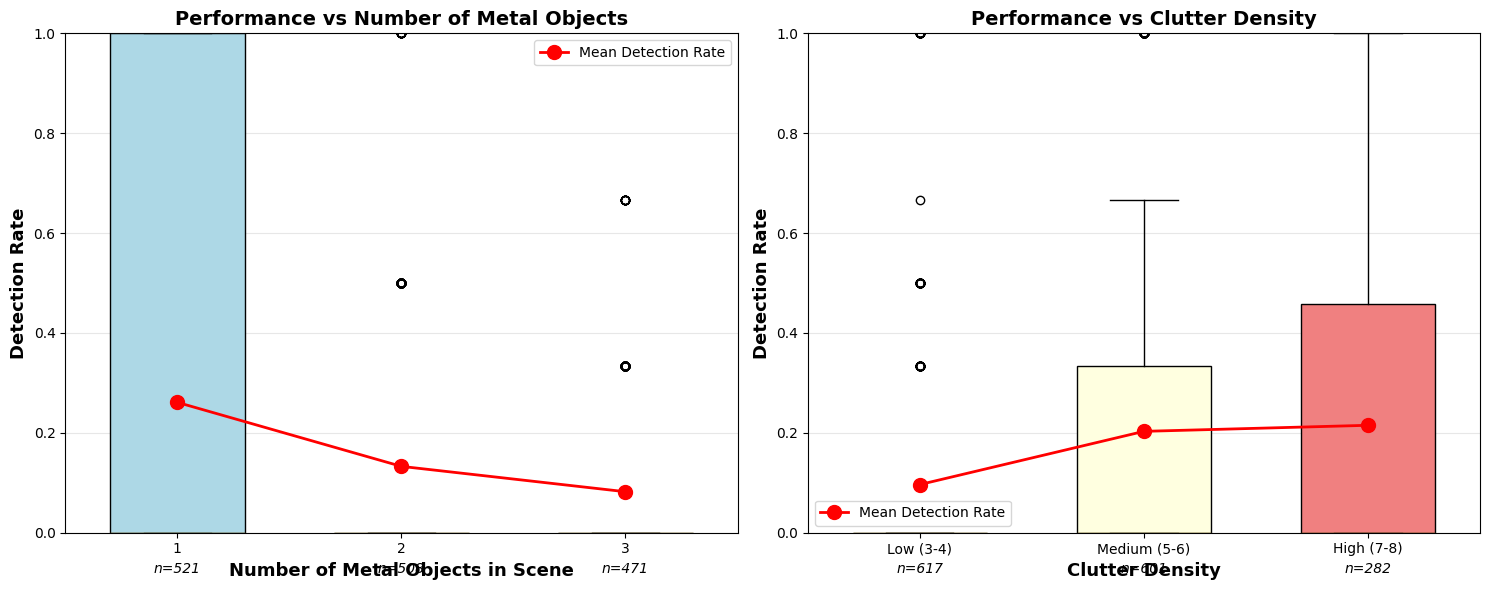


Performance by Number of Metal Objects:
  1 metal object(s): 26.1% ± 43.9%
  2 metal object(s): 13.3% ± 25.8%
  3 metal object(s): 8.2% ± 16.1%

Performance by Clutter Density:
  Low (3-4): 9.6% ± 24.8%
  Medium (5-6): 20.3% ± 36.0%
  High (7-8): 21.5% ± 35.1%


In [12]:
# Analyze performance based on scene complexity

# Group by number of metal objects
performance_by_metal = {1: [], 2: [], 3: []}
for rate, meta in zip(detailed_results['detection_rate'], metadata):
    num_metal = meta['num_metal']
    if num_metal in performance_by_metal:
        performance_by_metal[num_metal].append(rate)

# Group by number of clutter objects
clutter_ranges = {'Low (3-4)': [], 'Medium (5-6)': [], 'High (7-8)': []}
for rate, meta in zip(detailed_results['detection_rate'], metadata):
    num_clutter = meta['num_clutter']
    if num_clutter <= 4:
        clutter_ranges['Low (3-4)'].append(rate)
    elif num_clutter <= 6:
        clutter_ranges['Medium (5-6)'].append(rate)
    else:
        clutter_ranges['High (7-8)'].append(rate)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Performance by Number of Metal Objects
ax1 = axes[0]
metal_counts = sorted(performance_by_metal.keys())
box_data_metal = [performance_by_metal[k] for k in metal_counts]
bp1 = ax1.boxplot(box_data_metal, labels=metal_counts, patch_artist=True, widths=0.6)

for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')

# Add means
means_metal = [np.mean(data) for data in box_data_metal]
ax1.plot(range(1, len(means_metal) + 1), means_metal, 'ro-', 
         linewidth=2, markersize=10, label='Mean Detection Rate')

ax1.set_xlabel('Number of Metal Objects in Scene', fontsize=13, fontweight='bold')
ax1.set_ylabel('Detection Rate', fontsize=13, fontweight='bold')
ax1.set_title('Performance vs Number of Metal Objects', fontweight='bold', fontsize=14)
ax1.set_ylim([0, 1.0])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend()

# Add sample counts
for i, (count, data) in enumerate(zip(metal_counts, box_data_metal)):
    ax1.text(i + 1, -0.08, f'n={len(data)}', ha='center', fontsize=10, style='italic')

# 2. Performance by Clutter Density
ax2 = axes[1]
clutter_labels = list(clutter_ranges.keys())
box_data_clutter = [clutter_ranges[k] for k in clutter_labels]
bp2 = ax2.boxplot(box_data_clutter, labels=clutter_labels, patch_artist=True, widths=0.6)

colors_clutter = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp2['boxes'], colors_clutter):
    patch.set_facecolor(color)

# Add means
means_clutter = [np.mean(data) for data in box_data_clutter]
ax2.plot(range(1, len(means_clutter) + 1), means_clutter, 'ro-', 
         linewidth=2, markersize=10, label='Mean Detection Rate')

ax2.set_xlabel('Clutter Density', fontsize=13, fontweight='bold')
ax2.set_ylabel('Detection Rate', fontsize=13, fontweight='bold')
ax2.set_title('Performance vs Clutter Density', fontweight='bold', fontsize=14)
ax2.set_ylim([0, 1.0])
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

# Add sample counts
for i, (label, data) in enumerate(zip(clutter_labels, box_data_clutter)):
    ax2.text(i + 1, -0.08, f'n={len(data)}', ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('outputs_hidden/performance_by_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nPerformance by Number of Metal Objects:")
for count in metal_counts:
    mean_rate = np.mean(performance_by_metal[count])
    std_rate = np.std(performance_by_metal[count])
    print(f"  {count} metal object(s): {mean_rate*100:.1f}% ± {std_rate*100:.1f}%")

print("\nPerformance by Clutter Density:")
for label in clutter_labels:
    mean_rate = np.mean(clutter_ranges[label])
    std_rate = np.std(clutter_ranges[label])
    print(f"  {label}: {mean_rate*100:.1f}% ± {std_rate*100:.1f}%")